In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/Shareddrives/CSL/repo_seg/MAResUNet"

/content/drive/Shareddrives/CSL/repo_seg/MAResUNet


In [16]:
# import importlib
# import dataset
# importlib.reload(dataset)
# from dataset import *

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchsummary import summary

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from dataset import *
from MAResUNet import *
from eval.metrics import *

## Parametri iniziali

In [17]:
n_classes = 6 #sui modelli scaricati dal cluster bisognerà mettere giustamente 5
batch_size = 1
NUM_WORKERS = 0

size = 256
band = 3

folder_path = '/content/drive/MyDrive/data/Vaihingen/test/imgs'
mask_path = '/content/drive/MyDrive/data/Vaihingen/test/masks'
path = '/content/drive/MyDrive/data/Vaihingen/test/'

device = torch.device("cuda")

# Check dati test

In [41]:
l_i = len(os.listdir(folder_path))
l_m = len(os.listdir(mask_path))
print(l_i, l_m)

816 816


In [ ]:
test_list = np.random.randint(0, l_i, 5)

for n in test_list:
  im = os.listdir(folder_path)[n]
  mask = im[:-4] + '-mask.npy'
  a = np.load(folder_path + '/' + im)
  tiff.imshow(a)
  b = np.load(mask_path + '/' + mask)
  tiff.imshow(b, vmin=0, vmax=5)

## Studio andamento della loss

In [ ]:
train = pd.read_pickle(r'/content/drive/Shareddrives/CSL/CSL_Sox/U-Net_08_03/experiments/imagenet_13_04/crop_dataset/train_losses_imagenet_10_04_2021_23_39.pkl')
val = pd.read_pickle(r'/content/drive/Shareddrives/CSL/CSL_Sox/U-Net_08_03/experiments/imagenet_13_04/crop_dataset/val_losses_imagenet_10_04_2021_23_39.pkl')

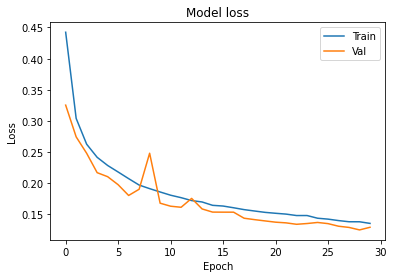

In [ ]:
plt.plot(train)
plt.plot(val)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Evaluation del modello

In [32]:
# best_model = torch.load('/content/drive/Shareddrives/CSL/repo_seg/MAResUNet/eval/netG_obow.pth', map_location=torch.device('cpu'))
best_model = torch.load('/content/drive/Shareddrives/CSL/repo_seg/MAResUNet/eval/netG.pth', map_location=torch.device('cpu'))
# best_model.keys()
b_m_weights = best_model#['model_state_dict']

In [33]:
encoder = models.__dict__['resnet18'](num_classes = n_classes)
b_m_weights = {key: b_m_weights[key] for key in b_m_weights if key not in ['base_model.fc.weight', 
                                                                       'base_model.fc.bias']}
net = MAResUNet(n_classes, base_model = encoder)
net.load_state_dict(b_m_weights, strict = False)

<All keys matched successfully>

In [37]:
val_dataset_ = train_dataset(path, size, size, 0, band)
val_iter = val_dataset_.data_iter_index(index = 300)
# val_iter = val_dataset_.data_iter()

In [ ]:
# net.to(device)

net.eval()

metrics = []

for initial_image, semantic_image in tqdm(val_iter, desc='val'):
    initial_image = initial_image#.cuda()
    semantic_image = semantic_image#.cuda()

    semantic_image_pred = net(initial_image).detach() 

    semantic_image_pred = F.softmax(semantic_image_pred.squeeze(), dim=0)
    semantic_image_pred = semantic_image_pred.argmax(dim=0)
    semantic_image = torch.squeeze(semantic_image.cpu(), 0)
    semantic_image_pred = torch.squeeze(semantic_image_pred.cpu(), 0)

    metric = eval_metrics(semantic_image_pred.long(), semantic_image.long(), n_classes)

    metrics.append(metric)

m_arr = np.mean(np.array(metrics), axis = 0)
print("\nOA:", m_arr[0], '\nACC_per_Class:', m_arr[1], 
        "\nJacc:", m_arr[2], "\nF1:", m_arr[3])

In [31]:
print("Prova MAResUNet Obow Vaihingen croppato")
print("\nOA:", m_arr[0], '\nACC_per_Class:', m_arr[1], 
        "\nJacc:", m_arr[2], "\nF1:", m_arr[3])

Prova MAResUNet Obow Vaihingen croppato

OA 0.9812728881835937 
ACC_per_Class 0.6565759807825089 
Jacc: 0.6378124494850635 
F1: 0.653084944486618


Prova MAResUNet ImageNet Vaihingen croppato

OA 0.9853854370117188 
ACC_per_Class 0.6567512345314026 
Jacc: 0.6453978288173675 
F1: 0.6574012181162834

Prova MAResUNet Obow Vaihingen croppato

OA 0.9812728881835937 
ACC_per_Class 0.6565759807825089 
Jacc: 0.6378124494850635 
F1: 0.653084944486618